# Chapter 7
# Decision Trees
## 7.1 Predicting the Price of a Used Car
### 7.1.2 How to Build a Decision Tree

To understand how decision trees are built, let's l the dataset behind the tree in figure 7-5 is the `12-cars.csv` dataset:

In [1]:
import pandas as pd
%matplotlib inline

cars_12 = pd.read_csv('../datasets/12-cars.csv', index_col=0)
cars_12

,Year,Engine,Power,Price
0,2003,1700,80,185
1,2005,1500,73,160
2,2008,1800,84,195
3,2009,1200,61,252
4,2010,1100,87,237
5,2016,1500,83,261
6,2012,1800,63,312
7,2011,1750,67,280
8,2010,1900,75,308
9,2009,1800,83,410


### 7.1.3 Coding a Primative Decision Tree

Decisions trees are built by recursively splitting regions of sapce into two sub-regions in order to minimize the mean squared error (MSE) across the training data. In each split, we choose the best pair of (feature, value) that would yeild the minimal MSE. We call this pair a **_pivot_**. To write a simple code that can apply this procedure and build us a decision tree on the 12-cars dataset, we first need to define the `Node` class which be the data structure holding the tree. 

In [2]:
class Node:
    
    def __init__(self, is_leaf=False, pivot=None):
        self.is_leaf = is_leaf
        self.pivot = pivot
        
    def attach_children(self, left, right):
        self.left_child = left
        self.right_child = right
        
    def attach_leaf_value(self, mean_value):
        self.leaf_value = mean_value
        
    def traverse(self, x):
        if not self.is_leaf:
            feature_indx, value = self.pivot
            if x[feature_indx] <= value:
                return self.left_child.traverse(x)
            else:
                return self.right_child.traverse(x)
        else:
            return self.leaf_value

The `Node` class represents a node in the decision tree, with left and right child nodes attached if the node is not a leaf node. With these properties, the root node object would represent the whole decision tree as it has links to all the child nodes underneath it. The `traverse` method allow us to travel down the tree with a given data point: on each decision node, comparison against the pivot is made to determine to which child shall we traverse next, until we reach a leaf node where we'll return the attached mean value of the labels in that leaf node region.

Next, we need to use the `Node` class in order to build the whole tree. We do so by defining a class called `PrimitiveDecisionTreeRegressor` that will hold our tree-building code. The two main method in that class are the `get_best_pivot` and the `split` methods. `get_best_pivot` enumerates all the possible values for each feature calculates the splitting MSE for each splitting option, the option with the smallest MSE is returned. The `split` method uses the `get_best_pivot` method to recursively split regions into two sub-regions until we hit the stopping criteria. 

In [3]:
import numpy as np

def mse(y_true, y_pred):
    # Calculating the mean square error (MSE)
    return np.mean((y_true - y_pred) ** 2)

class PrimitiveDecisionTreeRegressor:
    
    def __init__(self, stop_at=3):
        self.stop_at = stop_at
        self.tree = None
        
    def get_best_pivot(self, region_X, region_y):
        
        samples_count, features_count = region_X.shape
        
        # record each feature index with its possible values in a dictionary
        features_split_points = {}
        for i in range(features_count):
            features_split_points[i] = np.sort(region_X[:, i])
        
        # minimal mse is set to infinity at start
        minimal_mse = np.inf 
        best_pivot = (None, None)
        
        # we loop over all pairs of (feature_index, value)
        for i in range(features_count):
            for value in features_split_points[i]:
                
                # we make use of boolean masks to get the samples in each subregion
                left_region_mask = region_X[:, i] <= value
                right_region_mask = ~left_region_mask
                
                # we check the number of samples in each subregion
                # if it's lower than the stopping critreia, we omit that split
                left_region_X = region_X[left_region_mask]
                right_region_X = region_X[right_region_mask] 
                
                if left_region_X.shape[0] < self.stop_at or \
                    right_region_X.shape[0] < self.stop_at:
                    continue
                
                # we get the y values in each region and calculate the split MSE
                left_region_y = region_y[left_region_mask]
                right_region_y = region_y[right_region_mask]
                
                left_mse = mse(left_region_y, np.mean(left_region_y))
                right_mse = mse(right_region_y, np.mean(right_region_y))
                total_mse = left_mse + right_mse
                
                # if the split MSE is lower than the prvious best
                # we set the current split as the best one
                if total_mse < minimal_mse:
                    minimal_mse = total_mse
                    best_pivot = (i, value)
                    
        return best_pivot
        
        
    def split(self, region_X, region_y, level=1):
        
        samples_count, _ = region_X.shape
        
        # if the samples count in the region to split meets
        # the stopping criteria, stop recursion and return a leaf node
        if samples_count <= self.stop_at:
            leaf_node = Node(is_leaf=True)
            leaf_node.attach_leaf_value(np.mean(region_y))
            return leaf_node
    
        # get the best pivot at this step and craete a decision node            
        split_feature, split_value = self.get_best_pivot(region_X, region_y)
        current_node = Node(pivot=(split_feature, split_value))
        
        
        print("{}Split on feature {} at {}".format(
            ''.join(['\t'] * level), 
            split_feature, 
            split_value)
        )
        
        left_region_mask = region_X[:, split_feature] <= split_value
        right_region_mask = ~left_region_mask
        
        # recursivly split the left subregion and get its root node
        print("{}Left Region:".format(''.join(['\t'] * level)))
        left_region_X = region_X[left_region_mask]
        left_region_y = region_y[left_region_mask]
        left_child = self.split(left_region_X, left_region_y, level + 1)
        
        # recursivly split the right subregion and get its root node
        print("{}Right Region:".format(''.join(['\t'] * level)))
        right_region_X = region_X[right_region_mask]
        right_region_y = region_y[right_region_mask]
        right_child = self.split(right_region_X, right_region_y, level + 1)
        
        # attach the left and right subregions to the decision node
        current_node.attach_children(left_child, right_child)
        
        return current_node
    
    def fit(self, X, y):
        self.tree = self.split(X, y)
        
    def predict(self, x):
        return self.tree.traverse(x)

With this implementation, we're ready to train a decision tree on the 12-cars data we have. We made the implementation following the `scikit-learn` convention of fit/predict for consistency, we also added print statments that would layout how the tree is built to see if the splits matches the one we assumed true while we're visually building the tree in figure 7-8. Fitting the model would show us that the spilts are indeed correct.

In [4]:
X_train = cars_12.loc[:, "Year":"Power"].to_numpy()
y_train = cars_12.loc[:, "Price"].to_numpy()

primitive_dt = PrimitiveDecisionTreeRegressor()
primitive_dt.fit(X_train, y_train)

	Split on feature 0 at 2008
	Left Region:
	Right Region:
		Split on feature 1 at 1500
		Left Region:
		Right Region:
			Split on feature 2 at 75
			Left Region:
			Right Region:


And if we ran our testing example through the `predict` example, we would get the prediction of 300K as we stated before.

In [5]:
x_test = np.array([2012, 1600, 73])

primitive_dt.predict(x_test)

300.0

## 7.2 Building Decision Trees with scikit-learn
We start building a solution to the used cars price prediction problem by taking a look at the dataset we're going to work on. We begin by loading the training set and the held out tests set.

In [6]:
import pandas as pd

train_data = pd.read_csv("../datasets/used-cars-train.csv")
test_data = pd.read_csv("../datasets/used-cars-test.csv")

train_data.sample(10, random_state=42)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4235,3191,Mercedes-Benz A Class A180 CDI,Pune,2015,48300,Diesel,Automatic,First,20.0 kmpl,2143 CC,107.3 bhp,5.0,NaN,17.50
798,5761,Audi Q7 3.0 TDI Quattro Premium Plus,Coimbatore,2015,55662,Diesel,Automatic,First,12.07 kmpl,2967 CC,241.4 bhp,7.0,NaN,42.83
2321,1811,Honda Accord 2.4 AT,Kochi,2011,62332,Petrol,Automatic,First,11.7 kmpl,2354 CC,177.6 bhp,5.0,NaN,5.89
3352,3335,Toyota Corolla Altis 2008-2013 1.8 VL AT,Mumbai,2010,63298,Petrol,Automatic,First,14.53 kmpl,1794 CC,138.1 bhp,5.0,NaN,3.95
2304,4712,Hyundai Santro Xing XG,Pune,2003,80000,Petrol,Manual,Second,17.0 kmpl,NaN,NaN,NaN,NaN,0.90
2554,3225,Honda City V AT,Coimbatore,2012,60908,Petrol,Automatic,Second,15.6 kmpl,1497 CC,116.3 bhp,5.0,NaN,6.42
1606,1233,Mercedes-Benz E-Class 2015-2017 E250 CDI Avant...,Kochi,2017,36884,Diesel,Automatic,First,13.0 kmpl,2143 CC,204 bhp,5.0,NaN,32.25
3876,4849,Honda City i DTEC V,Delhi,2014,66500,Diesel,Manual,First,26.0 kmpl,1498 CC,98.6 bhp,5.0,NaN,5.70
705,3123,Tata Manza Aqua Safire,Mumbai,2010,41195,Petrol,Manual,First,15.0 kmpl,1368 CC,90 bhp,5.0,NaN,1.38
3907,1191,Toyota Etios GD SP,Coimbatore,2016,53702,Diesel,Manual,First,23.59 kmpl,1364 CC,67.04 bhp,5.0,NaN,6.55


Our data sample shows two problems that needs to be fixed before we can move forward:

1. The Mileage, Engine and Power data has their units attached to them, which makes `pandas` treat them a strings and hence categorical data. This data needs to be treated as numerical data.
2. There is a lot of `NaN`s and `0`s in the numeric columns, which indicates missing data that needs to filled

### 7.2.1 Preparing the Data

We start first by stripping the units from the numeric values and casting the remaining string into floats. This can be simply done using the `apply` method which applies a given function on all the elements of a `DataFrame`/`Series` and returns the result in a new `DataFrame`/`Series`.

In [7]:
import numpy as np

def strip_units(str_value):
    
    float_value = np.nan
    
    if str_value is not np.nan:
        number_str, units = str_value.split()
        try:
            float_value = float(number_str)
        except Exception:
            pass
    
    return float_value


def clean_dataframe(df):
    
    clean_data = df.copy(deep=True)
    
    clean_data.loc[:, 'Mileage'] = df.loc[:, 'Mileage'].apply(strip_units)
    clean_data.loc[:, 'Engine'] = df.loc[:, 'Engine'].apply(strip_units)
    clean_data.loc[:, 'Power'] = df.loc[:, 'Power'].apply(strip_units)
    
    return clean_data

train_data_clean = clean_dataframe(train_data)
test_data_clean = clean_dataframe(test_data)

A simple call to `clean_data.sample(10, random_sample=42)` will reveal that the units were stripped from the numeric values.

In [8]:
train_data_clean.sample(10, random_state=42)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4235,3191,Mercedes-Benz A Class A180 CDI,Pune,2015,48300,Diesel,Automatic,First,20.00,2143.0,107.30,5.0,NaN,17.50
798,5761,Audi Q7 3.0 TDI Quattro Premium Plus,Coimbatore,2015,55662,Diesel,Automatic,First,12.07,2967.0,241.40,7.0,NaN,42.83
2321,1811,Honda Accord 2.4 AT,Kochi,2011,62332,Petrol,Automatic,First,11.70,2354.0,177.60,5.0,NaN,5.89
3352,3335,Toyota Corolla Altis 2008-2013 1.8 VL AT,Mumbai,2010,63298,Petrol,Automatic,First,14.53,1794.0,138.10,5.0,NaN,3.95
2304,4712,Hyundai Santro Xing XG,Pune,2003,80000,Petrol,Manual,Second,17.00,NaN,NaN,NaN,NaN,0.90
2554,3225,Honda City V AT,Coimbatore,2012,60908,Petrol,Automatic,Second,15.60,1497.0,116.30,5.0,NaN,6.42
1606,1233,Mercedes-Benz E-Class 2015-2017 E250 CDI Avant...,Kochi,2017,36884,Diesel,Automatic,First,13.00,2143.0,204.00,5.0,NaN,32.25
3876,4849,Honda City i DTEC V,Delhi,2014,66500,Diesel,Manual,First,26.00,1498.0,98.60,5.0,NaN,5.70
705,3123,Tata Manza Aqua Safire,Mumbai,2010,41195,Petrol,Manual,First,15.00,1368.0,90.00,5.0,NaN,1.38
3907,1191,Toyota Etios GD SP,Coimbatore,2016,53702,Diesel,Manual,First,23.59,1364.0,67.04,5.0,NaN,6.55


To start addressing the missing values problem, we first need to represent all the missing value with a single reperesentation. So instead of having both `NaN` and `0` as representations of missing values, we transform all `0` values to `NaN` values as well.

In [9]:
train_data_clean = train_data_clean.replace(0, np.nan)
test_data_clean = test_data_clean.replace(0, np.nan)

With `NaN` as the representation for the missing values, we can run the following statement to get the percentage of missing values in each feature

In [10]:
train_data_clean.isnull().mean() * 100

Unnamed: 0            0.022153
Name                  0.000000
Location              0.000000
Year                  0.000000
Kilometers_Driven     0.000000
Fuel_Type             0.000000
Transmission          0.000000
Owner_Type            0.000000
Mileage               0.996899
Engine                0.575986
Power                 2.215330
Seats                 0.686752
New_Price            86.287107
Price                 0.000000
dtype: float64

With the big number of data missing from the `New_Price` feature, it'd be reasonable to drop that feature all together for now, along with the `Unnamed: 0` column which has no purpose.

In [11]:
train_data_clean = train_data_clean.drop(['New_Price', 'Unnamed: 0'], axis=1)
test_data_clean = test_data_clean.drop(['New_Price', 'Unnamed: 0'], axis=1)

For the other features with missing values, we can apply a simple imputation startegy, which replaces each missing value with the mean value of the existing values. But before we do that, we need to encode the categorical features and make the train-test split. We encode the categrocial feature using the `OrdinalEncoder` of `sklearn.preprocessing`. We also make use of `ColumnTransformer` from `sklearn.compose` to limit the ordinal encoding to the categorical columns only.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

categorical_features = [
    'Name','Location', 'Fuel_Type', 'Transmission', 'Owner_Type'
]

encoder = ColumnTransformer([
    ('categories_encoder', OrdinalEncoder(), categorical_features)
], remainder='passthrough')

all_clean_data = train_data_clean.append(test_data_clean)
encoded_data = encoder.fit(all_clean_data)

train_data_encoded = encoder.transform(train_data_clean)
test_data_encoded = encoder.transform(test_data_clean)

X_train, y_train = train_data_encoded[:, :-1], train_data_encoded[:, -1]
X_test, y_test = test_data_encoded[:, :-1], test_data_encoded[:, -1]

Now that we preprocessed our data, we can run the imputation process

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

X_test_imputed = imputer.transform(X_test)

Now our data is ready to train the decision tree.

### 7.2.2 Training and Evaluating the Decision Tree

Like any scikit-learn model, training a decision tree is nothing but running the `fit` method of a `DecisionTreeRegressor` object, which can be found in the `sklearn.tree module`.

In [14]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_imputed, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

To evaluate our trained decision tree on the testing data, we use the `mean_squared_error` function from `sklearn.metrics`.

In [15]:
from sklearn.metrics import mean_squared_error

y_predicted = model.predict(X_test_imputed)
mse = mean_squared_error(y_true=y_test, y_pred=y_predicted)
print("MSE = {:.2f}".format(mse))

MSE = 29.52


We can see that the MSE of our model is higher than 15, hence our decision tree cannot be accepted. We need to start thinking about how we can improve its performance and move it towards the acceptance criteria. We started our discussion of decision trees with one interesting property, and it was the fact that decision trees can be easily visualized. So in order to understand what this decision tree is doing wrong and attempt to improve, visualizing our trained tree would be good place to start.

Scikit-learn provides us with the ability to visualize trained decision trees with the help of 
known graph-drawing library called `graphviz`. With the `export_graphviz` function from the 
`sklearn.tree` module, we can export the trained tree in graphviz format (called dot format). 
Using the exported dot format of the tree, we can use the python bindings for graphviz to 
export the visualized tree in a PDF file that where we can examine the tree and inspect it. In order to do so, we need to install the python bindings to the `graphviz` library.

In [16]:
!conda install -y python-graphviz

Solving environment: done

# All requested packages already installed.



Now that we have the `graphviz` bindings installed, we can use the `export_graphviz` function to export our visualized tree into a pdf file.

In [17]:
from sklearn.tree import export_graphviz
import graphviz

numerical_features = [
    'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats'
]

dot_data = export_graphviz(
    model,
    # This allows the visualization to put feature names in decision nodes
    feature_names=categorical_features + numerical_features,
    # This makes the nodes with rounded corners
    rounded=True,
    # fills the nodes with gradient of colors indicating how high/low the decision value is
    filled=True,
    # uses special charcaters like ≤ instead of <
    special_characters=True
)

visualized_tree = graphviz.Source(dot_data)
visualized_tree.render("visulaized_tree")

'visulaized_tree.pdf'

When opening the `visualized_tree.pdf` file, we can see the tree is huge! It requires multiple 
zoom-ins to start seeing the nodes clearly. We can verify that this is the case for the whole tree by calling the `get_n_leaves()` method on our model to get the exact number of leaves and compare it to the number of training 
points in `X_train`. 

In [18]:
training_count, _ = X_train.shape
leaves_count = model.get_n_leaves()

print("{} data samples are put into {} leaf nodes".format(
    training_count, leaves_count
))

4514 data samples are put into 4286 leaf nodes


## 7.3 Trim the Tree or Grow Yourself a Forest

Instead of learning decision paths from multiple samples that are similar to each others, our model has learned unique decision paths for almost every sample in the training data. This is typical overfitting behavior. And over fitting means that the model is suffering from high variance, and this high variance needs to be reduced in order to get better performance.

Before we start exploring how we can lower the variance of our tree model, we first need to get an estimate of how high our current model’s variance is. Because the details of estimating a model’s variance is out of this chapter’s scope, we created a special function called `estimate_tree_variance` in the chapter’s `utils` module that can do that for us. This function takes the un-imputed version of the data and returns a float representing the estimated variance of decision trees on this data set.

In [19]:
from utils import estimate_tree_variance

tree_var = estimate_tree_variance(X_train, y_train)
print("Estimated Tree Variance = {:.2f}".format(tree_var))

Estimated Tree Variance = 15.22


### 7.3.1 Pruning the Tree

What caught our attention to the overfitting problem in our tree was the number of samples in each node, so it makes since that we tree to prune the tree (and hence lower its varaiance) by controling the minimum number of samples in a leaf node (to be graeter than one). This can be controlled by the `min_smaples_leaf` parameter of the `DecisionTreeRegressor`. We tune the value of this parameter through grid search on a validation set but this time we use `scikit-learn`'s `GridSearchCV` module that uses cross-validation to get better estimate of the validation scores _(read the section in the book to understand how cross-validation works)_

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# ensures random generations are the same across all runs
np.random.seed(42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('tree', DecisionTreeRegressor())
])

model_selector = GridSearchCV(pipeline, param_grid={
    'tree__min_samples_leaf': np.arange(1, 20),
}, scoring='neg_mean_squared_error', cv=5)

model_selector.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('tree',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,

we can access the best parameter and the best model through the `best_params_` and `best_estimator_` attributes. On interesting fact to note about the model living at `best_estimator_` is that this model is trained on the whole the training set using the best parametr found using k-fold CV.

In [21]:
print(model_selector.best_params_)
best_trimmed_tree = model_selector.best_estimator_

{'tree__min_samples_leaf': 7}


We can verify that the model found by k-fold CV performs better by calculating the test MSE of `best_trimmed_tree` and by checking the number of leaves in that tree model and its estimated variance.

In [22]:
best_trimmed_preds = best_trimmed_tree.predict(X_test)
best_trimmed_mse = mean_squared_error(y_test, best_trimmed_preds)

# we access steps of the pipeline like we get values from a dict
best_trimmed_n_leaves = best_trimmed_tree['tree'].get_n_leaves()
best_trimmed_variance = estimate_tree_variance(
    X_train, y_train, min_samples_leaf=7
)

print("[min_samples_leaf = 7] MSE = {:.2f}".format(best_trimmed_mse))
print("[min_smaples_leaf = 7] Leaves = {}".format(best_trimmed_n_leaves))
print("[min_smaples_leaf = 7] Variance = {:.2f}".format(best_trimmed_variance))

[min_samples_leaf = 7] MSE = 20.68
[min_smaples_leaf = 7] Leaves = 504
[min_smaples_leaf = 7] Variance = 9.03


While MSE was reduced by almost 9, the model’s error is still higher than the acceptance criteria. Although our new trimmed tree is much smaller (504 leaves vs. 4286 leaves) and has lower variance (9.03 vs. 15.22) compared to the un-pruned tree. It seems that we need to explore more ideas to lower the variance more in order to meet our acceptance criteria.

## 7.3.2 Random Forests

Another approach to reduce the variance of tree models is to train a large number of large trees and to take the a vote (or the mean) on the labels produced on each tree to produce the final label. In order for such approach to work, the trees need to be as uncorrelated as possible, so that the vote of one does not affect the other. This is done by training each tree on a subsample of the training set chosen randomly with replacement and by randmoly chosing a subset of the features to train the tree on. We train a random forsest with scikit-learn through the `RandomForestRegressor` class using k-fold cross validation to the chose the best number of features to train the tree upon. 

In [23]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

forest_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('forest', RandomForestRegressor(n_estimators=100))
])

forest_selector = GridSearchCV(
    forest_pipeline,
    param_grid = {
        'forest__max_features': np.arange(5, 12)
    },
    scoring='neg_mean_squared_error',
    cv=5
)
    
forest_selector.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('forest',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',


In that snippet, we train the forest while tuning the number of `max_features` starting from 5 to the maximum number of features, which is 11. We can access the best value for `max_features` through `forest_selector.best_params_` and the best forest trained on all data through `forest_selector.best_estimator_` as before:

In [24]:
print(forest_selector.best_params_)
best_forest = forest_selector.best_estimator_

{'forest__max_features': 5}


Now we can evaluate our forest against our held-out testing set and see that it exceeded the best trimmed tree we had before:

In [25]:
from utils import estimate_forest_variance

best_forest_preds = best_forest.predict(X_test)
best_forest_medae = mean_squared_error(y_test, best_forest_preds)

best_forest_variance = estimate_forest_variance(
    X_train, y_train, max_features=5
)

print("[Random Forest] MSE = {:.2f}".format(best_forest_medae))
print("[Random Forest] Variance = {:.2f}".format(best_forest_variance))

[Random Forest] MSE = 12.98
[Random Forest] Variance = 1.16


Random Forests gave us a reduction of around 8 in the prediction error, making it around 13 which is lower than the acceptance criteria. You did it! Now the model can be integrated in the supply pipeline of your colleague’s used car business. Even the variance of the forest is much lower than its pruned tree counterpart. Why is that? And how variance exactly affects error on testing data? Does that happen for decision trees only or it’s a general thing? These are questions to be answered by a little theoretical investigation that we can freely embark on 
now after we have delivered our product.

## 7.4 What Controls Generalization?

### 7.4.1 Why do Machine Learn from Data?

The main idea behind why machines can learn patterns from data is what's called the law of large numbers states that as the number of trials increases, the average outcome of a random experiment will get closer and closer to the true expected value. Take for example on of the simplest random experiments ever, tossing a fair coin; one would expect that we’ll get heads 50% of the times we toss a fair coin. The law of large number says that if we tossed that for some number of times, and at each toss we counted the number of times heads appeared so far, we’ll find that this count approaches 50% of the trials as we toss the coin more and more. We can simulate that programmatically using numpy.random.choice and pass it an array that has two elements `H` for heads and `T` for tails. This function will simulate a random choice between `H` and `T` with equal probability, which is what we 
expect from a fair coin.

In our little experiment below, we simulate tossing a fair coin for 10K times and at each trial we count the fraction of heads that we got so far, we’ll call that the empirical fraction. We then plot these fractions through time and compare it to the expected fraction, which is 50% (or 0.5 the times)

Text(0, 0.5, 'Heads Count Fraction')

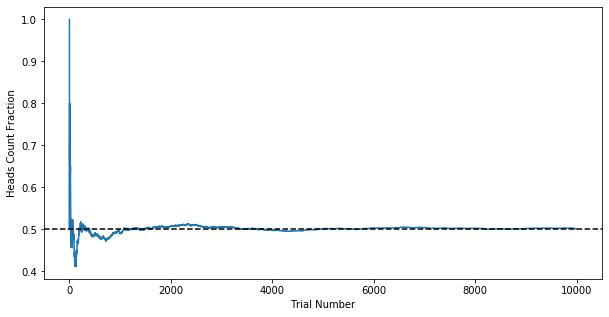

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

heads_count = 0
averages = []
for i in range(10000):
    sample = np.random.choice(['H', 'T'])
    heads_count += 1 if sample == 'H' else 0
    averages.append(heads_count / (i + 1))

_ = plt.figure(figsize=(10,5))
plt.plot(range(10000), averages)
plt.axhline(0.5, linestyle='--', color='black')
plt.xlabel("Trial Number")
plt.ylabel("Heads Count Fraction")

This comparison, as shown in plot above, demonstrates that the empirical fraction approaches the expected fraction as the number of trials increase. Or in other words, as the number of trials increase, it becomes less likely that the difference between the empirical fraction and the true fraction to be large. This last sentence is exactly what the mathematical formula of the law of large number says.

### 7.4.3 The Bias-Variance Trade-off

The trade-off between overfitting and underfitting is a universal problem throughout the whole realm of machine learning, and it goes by the name of bias-variance tradeoff. It’s usually the case with most machine learning models that when the model becomes more complex, the model overfits the training data and performs badly on new unseen samples. When the model’s complexity is reduced to avoid that situation, the model underfits the training data resulting in bad performance on unseen samples as well.

To see this in action, we can compare the training error and the testing error of a decision tree across different values for the leaves count. In the chapter’s `utils` module, we provided a function called `plot_train_test_variance_curves` that does this comparison for us. This function does the following:

1. Train different decision trees with different leaf nodes count from small to large and records the tree’s MSE on the training data and the testing data. Moreover, it records an estimate variance for a tree with such size.
2. After that, the function draws two plots:

  1. One plot showing the testing error vs. the training error over different leaves count.
  2. Another plot showing the generalization gap (|testing error - training error|) vs the variance over different  leaves count. This should help us understand the relation between the generalization bound above and the variance of the model. Using this function is pretty simple, we just need to send it the training and testing data, un imputed.

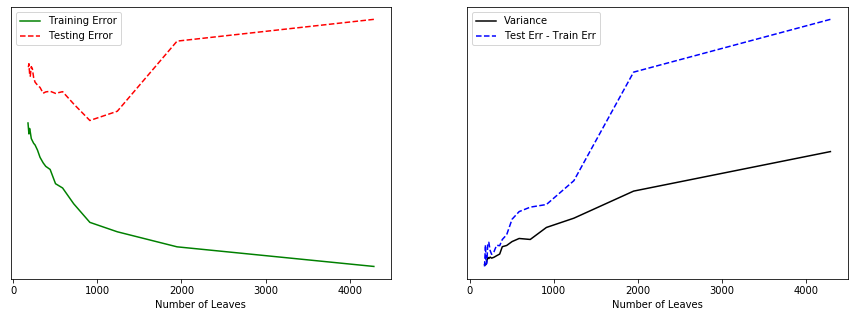

In [27]:
from utils import draw_tree_learning_curves

draw_tree_learning_curves(X_train, y_train, X_test, y_test)

### 7.4.4 Why do Random Forests Work so Well?

The power of random forests comes form the fact that its variance is essentially the variance of a single decision tree divided by the number of trees ($q$) in the forest plus a samll value representing the correlation between the forest's trees.

$$
Var(H_{RF}) = \frac{Var(H_{DT})}{q} + \text{small value}
$$

We can actually verify that by running the `estimate_tree_variance` and `estimate_forest_variance` on our data and see that the estimated forest variance only 1.08 above the variance of trees divided by 100 (the number of tress in the forest).

In [28]:
np.random.seed(42)

tree_variance = estimate_tree_variance(X_train, y_train, max_features=5)
forest_variance = estimate_forest_variance(X_train, y_train, max_features=5)

diff = forest_variance - (tree_var / 100)
print("Var(HRF) - (Var(HDT) / 100) = {:.2f}".format(diff))

Var(HRF) - (Var(HDT) / 100) = 1.08
